In [ ]:
import random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List
from torch.utils.data import Dataset, DataLoader

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs): return x

SEED = 7
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

if device.type == "cuda":
    torch.backends.cudnn.benchmark = True

@dataclass
class WorldConfig:
    grid_size: int = 8
    cell_px: int = 14
    max_steps: int = 45
    n_obstacles: int = 8
    spawn_margin: int = 1

class GridWorldRGBNoPIL:
    ACTIONS = {0:(0,-1),1:(0,1),2:(-1,0),3:(1,0),4:(0,0)}
    ACTION_NAMES = {0:"UP",1:"DOWN",2:"LEFT",3:"RIGHT",4:"STAY"}

    def __init__(self, cfg: WorldConfig):
        self.cfg = cfg
        self.reset()

    def reset(self) -> Dict:
        g = self.cfg.grid_size
        self.steps = 0
        def sample_empty(exclude=set()):
            while True:
                x = random.randint(self.cfg.spawn_margin, g-1-self.cfg.spawn_margin)
                y = random.randint(self.cfg.spawn_margin, g-1-self.cfg.spawn_margin)
                if (x,y) not in exclude: return (x,y)
        self.obstacles = set()
        ax, ay = sample_empty()
        gx, gy = sample_empty(exclude={(ax,ay)})
        used = {(ax,ay),(gx,gy)}
        for _ in range(self.cfg.n_obstacles):
            ox, oy = sample_empty(exclude=used)
            self.obstacles.add((ox,oy))
            used.add((ox,oy))
        self.agent = (ax,ay)
        self.goal = (gx,gy)
        return {"image": self._render_u8()}

    def _in_bounds(self, x, y):
        return 0 <= x < self.cfg.grid_size and 0 <= y < self.cfg.grid_size

    def _dist_to_goal(self, pos: Tuple[int,int]) -> float:
        x,y = pos; gx,gy = self.goal
        return abs(x-gx)+abs(y-gy)

    def _state_vector(self) -> np.ndarray:
        g = self.cfg.grid_size - 1
        ax,ay = self.agent; gx,gy = self.goal
        return np.array([ax/g, ay/g, gx/g, gy/g], dtype=np.float32)

    def step(self, action: int):
        self.steps += 1
        dx, dy = self.ACTIONS[int(action)]
        x,y = self.agent
        nx, ny = x+dx, y+dy
        if self._in_bounds(nx,ny) and (nx,ny) not in self.obstacles:
            self.agent = (nx,ny)
        done = (self.agent == self.goal) or (self.steps >= self.cfg.max_steps)
        d_prev = self._dist_to_goal((x,y))
        d_now = self._dist_to_goal(self.agent)
        reward = 0.1*(d_prev - d_now) + (1.0 if self.agent == self.goal else 0.0)
        obs = {"image": self._render_u8()}
        info = {"state": self._state_vector()}
        return obs, float(reward), bool(done), info

    def _render_u8(self) -> np.ndarray:
        g, s = self.cfg.grid_size, self.cfg.cell_px
        H = W = g*s
        bg = np.array([245,245,245], np.uint8)
        gridline = np.array([220,220,220], np.uint8)
        obstacle_c = np.array([220,70,70], np.uint8)
        goal_c = np.array([60,180,75], np.uint8)
        agent_c = np.array([65,105,225], np.uint8)
        img = np.empty((H,W,3), np.uint8); img[...] = bg
        img[::s,:,:] = gridline
        img[:,::s,:] = gridline
        def paint_cell(x,y,color):
            y0,y1 = y*s,(y+1)*s
            x0,x1 = x*s,(x+1)*s
            img[y0+1:y1-1, x0+1:x1-1] = color
        for (ox,oy) in self.obstacles: paint_cell(ox,oy, obstacle_c)
        gx,gy = self.goal; paint_cell(gx,gy, goal_c)
        ax,ay = self.agent; paint_cell(ax,ay, agent_c)
        return img

cfg = WorldConfig()
env = GridWorldRGBNoPIL(cfg)
plt.figure(figsize=(3,3))
plt.imshow(env.reset()["image"]); plt.axis("off"); plt.title("No-Pillow observation"); plt.show()

def to_tensor_img_u8(img_u8: np.ndarray) -> torch.Tensor:
    return torch.from_numpy(img_u8).permute(2,0,1).float() / 255.0

In [ ]:
class TransitionDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, i): return self.items[i]

def collect_transitions(n_episodes=120):
    items = []
    e = GridWorldRGBNoPIL(cfg)
    for _ in tqdm(range(n_episodes), desc="Collect"):
        obs = e.reset()
        img_t = to_tensor_img_u8(obs["image"])
        for _ in range(cfg.max_steps):
            a = random.randint(0,4)
            obs2, r, done, info = e.step(a)
            img_tp1 = to_tensor_img_u8(obs2["image"])
            st = torch.from_numpy(info["state"]).float()
            goal = st[2:4].clone()
            items.append({
                "img_t": img_t,
                "action": torch.tensor(a, dtype=torch.long),
                "img_tp1": img_tp1,
                "state_tp1": st,
                "goal": goal
            })
            img_t = img_tp1
            if done: break
    return items

items = collect_transitions(n_episodes=120)
print("Transitions:", len(items))
H, W = items[0]["img_t"].shape[1], items[0]["img_t"].shape[2]
dl = DataLoader(TransitionDataset(items), batch_size=64, shuffle=True, num_workers=0, drop_last=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, H, W, zdim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(24, 48, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(48, 64, 3, stride=2, padding=1), nn.ReLU(),
        )
        with torch.no_grad():
            f = self.net(torch.zeros(1,3,H,W))
        self.feat_shape = f.shape[1:]
        self.fc = nn.Linear(int(np.prod(self.feat_shape)), zdim)
    def forward(self, x):
        return self.fc(self.net(x).flatten(1))

class Decoder(nn.Module):
    def __init__(self, feat_shape, zdim=64):
        super().__init__()
        C,h,w = feat_shape
        self.C,self.h,self.w = C,h,w
        self.fc = nn.Linear(zdim, C*h*w)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(C, 48, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(24, 16, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(16, 3, 3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, z):
        x = self.fc(z).view(z.size(0), self.C, self.h, self.w)
        return self.net(x)

class VLASimLite(nn.Module):
    def __init__(self, H, W, zdim=64, adim=5):
        super().__init__()
        self.enc = Encoder(H,W,zdim)
        self.dec = Decoder(self.enc.feat_shape, zdim)
        self.aemb = nn.Embedding(adim, 16)
        self.gnet = nn.Sequential(nn.Linear(2,16), nn.ReLU(), nn.Linear(16,16))
        self.dyn = nn.Sequential(
            nn.Linear(zdim+16+16, 128), nn.ReLU(),
            nn.Linear(128, zdim)
        )
        self.state = nn.Sequential(
            nn.Linear(zdim, 64), nn.ReLU(),
            nn.Linear(64, 4),
            nn.Sigmoid()
        )
    def encode(self, img): return self.enc(img)
    def predict_next_latent(self, z, a, goal):
        return self.dyn(torch.cat([z, self.aemb(a), self.gnet(goal)], dim=-1))
    def decode(self, z): return self.dec(z)
    def forward(self, img_t, a, goal):
        z = self.encode(img_t)
        z_next = self.predict_next_latent(z, a, goal)
        return z_next, self.decode(z_next), self.state(z_next)

model = VLASimLite(H,W,zdim=64,adim=5).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-3)

In [ ]:
def train(epochs=4):
    model.train()
    for ep in range(1, epochs+1):
        losses = []
        for b in tqdm(dl, desc=f"Train {ep}/{epochs}"):
            img_t = b["img_t"].to(device)
            a = b["action"].to(device)
            img_tp1 = b["img_tp1"].to(device)
            st_tp1 = b["state_tp1"].to(device)
            goal = b["goal"].to(device)
            z_next, img_pred, st_pred = model(img_t, a, goal)
            loss = F.l1_loss(img_pred, img_tp1) + 3.0*F.mse_loss(st_pred, st_tp1) + 1e-4*z_next.pow(2).mean()
            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            opt.step()
            losses.append(loss.item())
        print("Epoch", ep, "loss", float(np.mean(losses)))

train(epochs=4)

Device: cpu


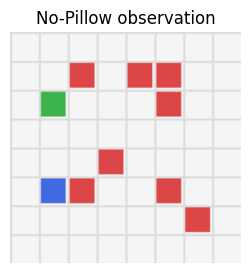

Collect:   0%|          | 0/120 [00:00<?, ?it/s]

Transitions: 4424


Train 1/4:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 1 loss 0.3522709936335467


Train 2/4:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2 loss 0.227385635825171


Train 3/4:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3 loss 0.15279922850322034


Train 4/4:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 4 loss 0.07108443295178206
Steps: 3 Return: 1.1


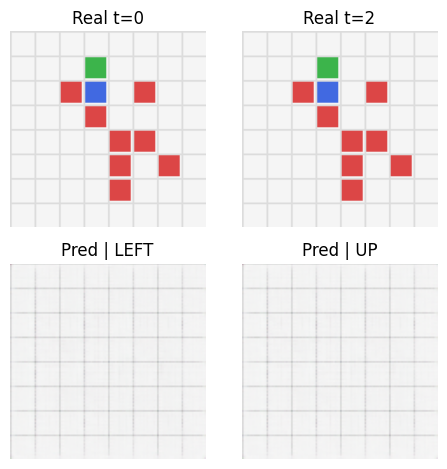


Pipeline OK: Perception (img->latent->state) | Planning (MPC) | Prediction (next frame) | Replan (closed-loop)



In [1]:
@torch.no_grad()
def mpc_action(img_t, horizon=6, n_candidates=120, action_space=5):
    model.eval()
    z = model.encode(img_t)
    st_now = model.state(z)
    goal = st_now[:,2:4].clamp(0,1)
    cand = torch.randint(0, action_space, (n_candidates, horizon), device=device)
    z_roll = z.repeat(n_candidates, 1)
    goal_k = goal.repeat(n_candidates, 1)
    for t in range(horizon):
        z_roll = model.predict_next_latent(z_roll, cand[:,t], goal_k)
    stT = model.state(z_roll)
    dist = torch.abs(stT[:,0:2] - stT[:,2:4]).sum(dim=-1)
    changes = (cand[:,1:] != cand[:,:-1]).float().mean(dim=1)
    score = dist + 0.12*changes
    best = torch.argmin(score)
    return int(cand[best,0].item())

@torch.no_grad()
def predict_next_frame(img_u8, action):
    model.eval()
    img_t = to_tensor_img_u8(img_u8).unsqueeze(0).to(device)
    z = model.encode(img_t)
    goal = model.state(z)[:,2:4].clamp(0,1)
    a = torch.tensor([action], dtype=torch.long, device=device)
    z_next = model.predict_next_latent(z, a, goal)
    pred = model.decode(z_next)[0].detach().cpu().permute(1,2,0).numpy()
    return (pred*255.0).clip(0,255).astype(np.uint8)

def run_episode(max_steps=45):
    e = GridWorldRGBNoPIL(cfg)
    obs = e.reset()
    real, pred, acts, rews = [], [], [], []
    for _ in range(max_steps):
        img = obs["image"]
        real.append(img)
        a = mpc_action(to_tensor_img_u8(img).unsqueeze(0).to(device), horizon=6, n_candidates=120)
        pred.append(predict_next_frame(img, a))
        obs, r, done, info = e.step(a)
        acts.append(a); rews.append(r)
        if done:
            real.append(obs["image"])
            pred.append(pred[-1])
            break
    return real, pred, acts, rews

real, pred, acts, rews = run_episode()
print("Steps:", len(acts), "Return:", round(sum(rews), 3))

def show(real, pred, acts, every=2, panels=8):
    idxs = list(range(0, min(len(acts), every*panels), every))
    n = len(idxs)
    plt.figure(figsize=(2.4*n, 4.8))
    for j,i in enumerate(idxs):
        plt.subplot(2,n,j+1); plt.imshow(real[i]); plt.axis("off"); plt.title(f"Real t={i}")
        plt.subplot(2,n,n+j+1); plt.imshow(pred[i]); plt.axis("off"); plt.title(f"Pred | {GridWorldRGBNoPIL.ACTION_NAMES[acts[i]]}")
    plt.tight_layout(); plt.show()

show(real, pred, acts, every=2, panels=8)
print("Pipeline OK")